<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Мини-домашка 7: классификация

В 6 мини-домашки мы пытались решить задачу регрессии и спрогнозировать какое коилчество лайков пользователь оставит в паблике с мемами. У нас это вышло не очень удачно. Давайте попробуем построить модель, которая могла бы ответить на вопрос "А поставит ли человек лайк в паблик в принципе?". Возможно, что хотябы здесь нас ждёт успех. 

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import matplotlib
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

In [2]:
# Метрики для измерения качества алгоритмов 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [3]:
# Функции для визуализации метрик 
import itertools

# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass


# Картинки для PR-кривой, а-меры и прочих ништяков
def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

# 1. Снова подгружаем данные

В очередной раз подгрузим немного данных. 

In [4]:
df = pd.read_csv('../data/vk_main.csv', sep='\t')   # подгружаем датасет
df.head()

,city,country,first_name,home_town,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Артём,MOSCOW,Еркин,0,181029517,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.0,0.375000
1,NaN,Россия,Армен,NaN,Хачатрян,15,73703994,1,0,1,...,1.750000,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,47.0,0.531915
2,Москва,Россия,Abbos,Бекабад,Akhmedov,11,467673028,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,26.0,0.500000
3,Москва,Россия,Адам,NaN,Триандафилиди,0,144910934,1,0,1,...,1.428571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,83.0,0.518072
4,Алматы,Казахстан,Айжан,NaN,Саят,9,166045266,0,0,0,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,0.344828


In [5]:
# варим таргет в виде ответа на вопрос "а он лайкнул мем хотя бы раз?"
df['ln_likes_memes'] = df['likes_memes'] > 0

Ровно также, как мы это делали на семинаре, предобработаем данные. Если вы не понимаете какую-то из строчек в следущем большом кодище, выясните как она работает. Напишите в чат тех-поддержки, семинаристу, сходите к гадалке. Сделайте хоть что-то, потому что скоро такой код вам придётся писать самостоятельно. 

In [6]:
# выбрасываем из выборки все переменные, в которых слишком много пропусков
isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

# Выборка с переменными-счётчиками
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']

# Оставляем только информативные переменные (картинки можно посмотреть в семинарской тетрадке)
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

# логарифмируем счётчики
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# отбираем дамми - переменные 
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']

# средние, медианы и максимумы
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_max = [item for item in df.columns if item[-3:] == 'max']

# все полезные переменные
useful_variables = variables_cnt + variables_dummy + variables_mean + \
                   variables_median + variables_max + ['friends_mail_from_course_pct']

# заполняем пропуски нулями
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,country,first_name,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,skype_dummy,twitter_dummy,...,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct,ln_likes_memes
0,Россия,Артём,Еркин,0,181029517,1,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2.833213,0.375000,False
1,Россия,Армен,Хачатрян,15,73703994,1,0,1,0,0,...,1.609438,1.0,0.571429,1.0,0.0,0.0,0.0,3.871201,0.531915,True
2,Россия,Abbos,Akhmedov,11,467673028,1,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,3.295837,0.500000,True
3,Россия,Адам,Триандафилиди,0,144910934,1,0,1,1,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4.430817,0.518072,False
4,Казахстан,Айжан,Саят,9,166045266,0,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,3.401197,0.344828,True


# 2. Подготовка к моделированию.

Начнём с простого. 

__[1]__ Разделите выборку на тренировочную и тестовую. Запишите обучающую выборку в табличку `df_train`, а тестовую в `df_test`.

In [7]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42) 

Для удобства запишем в `y` то, что мы хотим прогнозировать.

In [8]:
y_train = df_train['ln_likes_memes'].get_values()
y_test = df_test['ln_likes_memes'].get_values()

Посмотрим как соотносятся доли лайкавших и нелайкавших в тренировочной и тестовой выборках.

In [9]:
np.mean(y_train), np.mean(y_test)

(0.6455223880597015, 0.582089552238806)

В `X` запишем то, по чему мы будем прогнозировать. 

In [10]:
# Забираем в выборку лучших из лучших 
X_train = df_train[useful_variables].get_values()
X_test = df_test[useful_variables].get_values()

# 3. Метод ближайшего соседа

Начнём моделирование с метода ближайшего соседа. 

__[1]__ Проскалируйте переменные. Поясните в виде текста зачем нужно это делать. Надо ли скалировать переменные для деревьев? 

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler( )
scaler.fit(X_train) 

X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

__[1]__ Обучите на тренировочной выборке алгоритм 10 ближайших соседей. Запишите прогнозы алгоритма в переменную `y_predict`.

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_norm, y_train)
y_predict = knn.predict(X_test_norm)

Построим для получившегося алгоритма roc-кривую на тестовой выборке. 

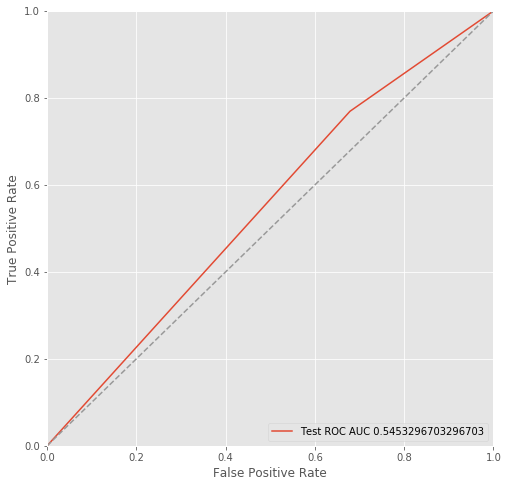

In [13]:
# Для леса
roc_auc_pic(y_predict, y_test)

Посмотрим какой получилось accuracy (доля правильных ответов). 

In [14]:
accuracy_score(y_test, y_predict)

0.582089552238806

__[1]__ Какой вывод о прогнозной силе алгоритма вы можете сделать? Можно ли в данной ситуации в качестве метрики использовать `acuracy`? 

__Ответ:__  Тут должно быть написано, что всё плохо

# 4. Пытаемся улучшить работу алгоритма

Давайте попытаемся выжать из метода ближайших соседей максимум. 

__[2]__ Попробуйте перебрать разное количество соседей и разные дистанции. Насколько получилось улучшить работу классификатора? 

In [15]:
# Решётка для перебора 
from sklearn.model_selection import GridSearchCV

# параметры, которые мы будем перебирать 
parameters = {
     'n_neighbors':range(5, 16),         # число соседей от 5 до 15
     'weights':['uniform', 'distance']   # надо ли более близких соседей учитывать с большим весом
             }

# объявили модель
knn_clf = KNeighborsClassifier()

# завернули её в решётку для поиска параметров
grid_knn = GridSearchCV(knn_clf, parameters, cv=3, scoring="roc_auc")

# обучаем нашу решётку (если мы хотим перебрать много параметров, обучение будет идти долго) 
grid_knn.fit(X_train_norm, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(5, 16), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Какое сочетания параметров оказалось оптимальным? Какое качество показывает алгоритм? 

In [16]:
grid_knn.best_score_

0.5266296713060336

In [17]:
grid_knn.best_params_

{'n_neighbors': 12, 'weights': 'distance'}

# 5. Дерево 

__[2]__ Продолжаем наше путешествие в классификацию. Постройте решающее дерево. Какое качество оно показывает на тренировочной выборке? А на тестовой? Что такое переобучение? Правда ли, что дерево переобучилось? 

In [20]:
# Подшружаем дерево 
from sklearn.tree import DecisionTreeClassifier

# Объявляем дерево 
tree = DecisionTreeClassifier( )

# учим дерево 
tree.fit(X_train_norm, y_train)

# предсказываем на обучающей выборке результат
y_predicted = tree.predict(X_train_norm)

# качество на трэйне 
print('accuracy:', accuracy_score(y_train, y_predicted))
print('roc_auc:', roc_auc_score(y_train, y_predicted), '\n')

# предсказываем на тестовой выборке результаты 
y_predicted = tree.predict(X_test_norm)

# качество на тесте
print('accuracy:', accuracy_score(y_test, y_predicted))
print('roc_auc:', roc_auc_score(y_test, y_predicted))

accuracy: 0.9738805970149254
roc_auc: 0.9679038637055065 

accuracy: 0.6119402985074627
roc_auc: 0.576007326007326


__Ответ:__  тут нужно написать о том, что на трэйне качество получилось на порядок выше, и это сигнализирует о наличии переобучения.

# 6. Случайный лес 

__[2]__ Попробуйте обучить случайный лес, посмотрите на качество его работы по метрике roc_auc. 

In [21]:
# Подшружаем случайный лес
from sklearn.ensemble import RandomForestClassifier

# объявляем его, будем учить 1000 деревьев
forest = RandomForestClassifier(n_estimators=1000)

# учим лес 
forest.fit(X_train_norm, y_train)

# строим предсказания 
y_predicted = forest.predict(X_test_norm)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_predicted))
print('roc_auc:', roc_auc_score(y_test, y_predicted))

accuracy: 0.5373134328358209
roc_auc: 0.4665750915750916


* Зачем деревья объединяют в лес? 

__Ответ:__  чтобы улучшить качество, каждое дерево облизывает часть выборки и в сумме они принимают хорошее решение 

* Какой из трёх обученных выше алгоритмов показал наилучшее качество? 

__Ответ:__ .... 

* Как считате, удалось ли нам научиться предсказывать, что студент первого курса поставит в паблик лайк? С чем это на ваш взгляд связано? 

__Ответ:__  нет, мало данных, переменные обладают слабой объясняющей силой, возможно вообще нет взаимосвязи и тп 
